## Traffic Sign Classification

To implement the traffic sign classification, we are going to use the dataset expose for the German Traffic Sign Benchmark competition. Details about the competition could be found [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news).

### Global environment specific configuration settings

To make sure the code is able to run across multiple environments with different constraints, we are going to define fine grained configuration controls. The config dictionary below is a single place where configuration values are specieid. This should be modified to change the default environment specific assumptions.

In [1]:
config = {
    "dataset": "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip", # URI for training set.
    "batches": 5, # Number of batches to divide the dataset into.
    "local_cache_path": "./", # File system path to cache the downloaded images.
    "data_dir": "traffic_signs_data", # Directory to keep raw un-processed data.
    "preprocessed_data_dir": "preprocessed_data" #Directory to hold the pre-processed training, validation and test data.
}

### Getting the data

The INI benchmarks website hosts the data used for GTSRB comptetion [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news). The dataset consist of 39,209 images for training the model and 12,630 images for the testing purpose. Instead of using the original dataset hosted on the website, we are going to use the dataset available [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This is the same dataset with some pre-processing already done. There are few things we get by using this:

- The images are resize to 32x32 pixels.
- The images are orgnized into train, validation and test set.

The code cell below would help us to download this dataset if not available and keep it ready for the analysis.

In [2]:
"""
Download the data from the web and cache it on the local device.
"""

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

# Define the base path to save the dataset.
base_dir = config["local_cache_path"]
data_dir = base_dir + config["data_dir"]

# Define the dataset file names,
raw_data_file = "traffic-signs-data.zip"


class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Utility to download the data if not already present.
def cache(target_file, cache_dir, download_uri, description=''):
    '''
        If cache hit - return
        If cache misss - Download the data and cache locally.
        @param target_file: The file to cache.
        @param cache_dir: The target directory to keep the cached files.
        @param download_uri: URI to download the file if not present.
        @param description: To display the progress message.
    '''
    path = cache_dir + target_file

    if not isfile(path):
        description = description or target_file
        try:
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc=description) as pbar:
                urlretrieve(download_uri, path, pbar.hook)
        except Exception as e:
            print("Issue downloading the file: {}".format(e.message))

def unzip(file_to_unzip, target_dir, cache_dir):
    '''
        If the target directory is not present, unzip the file into a target directory.
    '''
    path = cache_dir + target_dir
    file_path = cache_dir + file_to_unzip

    if not isdir(path):
        with zipfile.ZipFile(file_path) as zipf:
            zipf.extractall(path)
            zipf.close()

# Get the raw dataset.
cache(raw_data_file, base_dir, config["dataset"])

# Unzip the dataset to extract the training, validation and test set.
unzip(raw_data_file, data_dir, base_dir)

### Loading the training and validation set.

Let us load the training and validation set for us to do the data analysis and visualizations.


In [3]:
import utils

train_set, valid_set = utils.load_train_and_validation_set(config["local_cache_path"], config["data_dir"])

train_features = train_set["features"]
train_labels = train_set["labels"]

valid_features = valid_set["features"]
valid_labels = valid_set["labels"]

print("Total images for training: {}".format(len(train_labels)))
print("Total images for validation: {}".format(len(valid_labels)))

Total images for training: 34799
Total images for validation: 4410


### Data Analysis and Visulizations

Exploratory Data Analysis is one of the very important step in the process of solving any machine learning problem. In the code cells that follow, we are going to analyze important aspects of our dataset to gain the better understanding.

#### Training and Validation set - Class Distribution

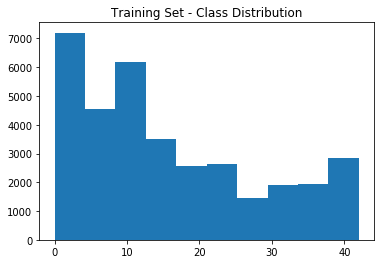

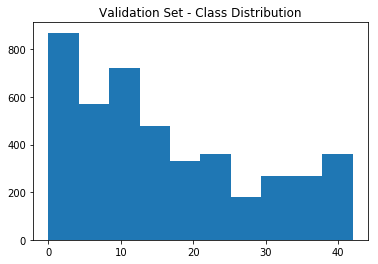

In [4]:
%matplotlib inline

utils.plot_class_distirbution(train_labels, "Training Set - Class Distribution")
utils.plot_class_distirbution(valid_labels, "Validation Set - Class Distribution")

Looking at the graphs above, we can make following observation:

- The training set and the validation set distribution is similar
- All the classes are covered / represented in the validation set.


#### Class Descriptions:

Let us load the class descriptions for each of the classes represented in the dataset, to get a view of what traffic signs have been covered.

In [5]:
import pandas as pd

label_ids = list(range(43))
label_desc = utils.load_label_names()
label_ids_desc = list(zip(label_ids, label_desc))

pd.DataFrame(label_ids_desc, columns=["Class ID", "Description"])

,Class ID,Description
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


#### Display Sample of Traffic Signs

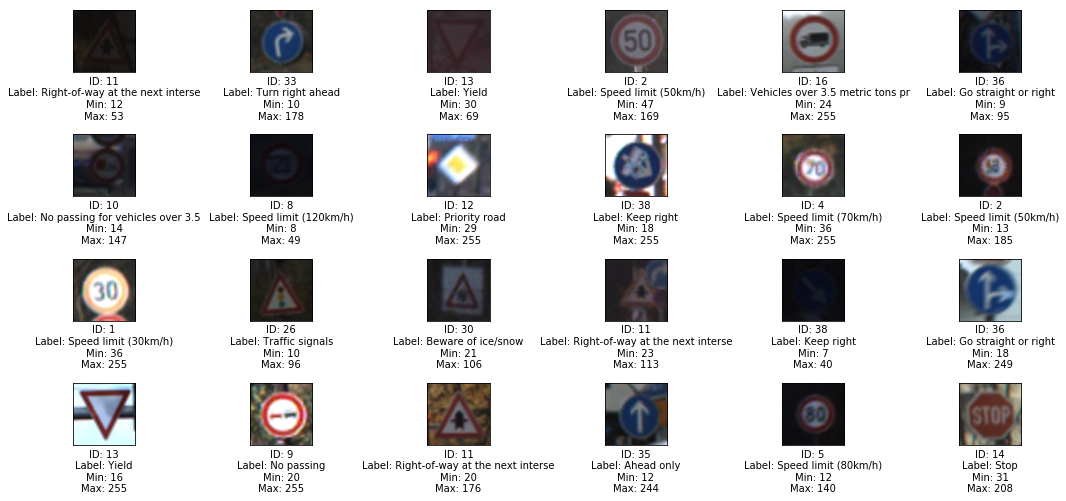

In [6]:
# Display some randomly sampled images from the training set with relevant metadata.
utils.display_sample_images(train_features, train_labels, label_desc)

#### Observations:

As can be seen above, we have images of 32x32 each, where the min pixel value is 0 and max is 255. There are 3 color channels with one byte size each (8 bits to hold values between 0 to 255) and hence each image is 32x32x3 bytes in size. 

Some of the images shown above belong to the same class, and as we can see, even though they represent the same traffic sign, they look quite different from each other. Some images are very clear and bright, while others are very dull, some are distorted and damaged, while others suffer from sun glare. Our machine learning models needs to learn the general pattern such a way that these variations doesn't play the important role to predict the outcome.


#### Grey Scaling:

As we may notice, some traffic signs have different colors than the others. While images for classes like 'Keep Left', 'Ahead Only' are primarily represented in blue, the other classes like 'Yield' and 'Speed Limit' are primarily represented in red. Though colors may be somewhat helpful for the human eye, it may not be very useful for building the models. For the model to be reliable, we want the models to learn the general patterns that define the traffic sign, rather than basing their predictions based on the colors. To make our models independent of the colors, we are going to convery the RGB images into gray scale images. This also has the added advantage of lesser memory foot print. While the RGB image would need 32x32x3 bytes each, the gray scale images would be stored in 32x32 bytes, a reduction of x3.

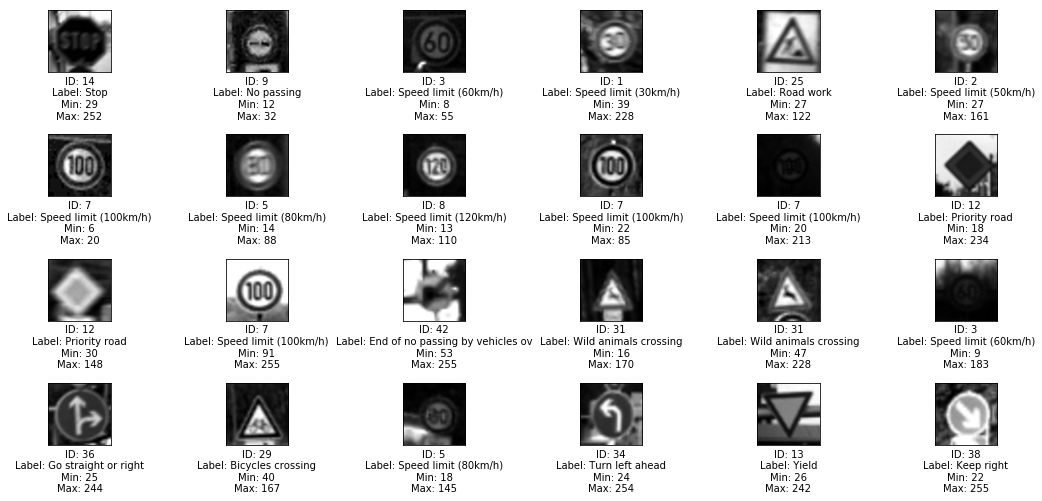

In [7]:
# Convert RGB images to grey scale and display the sample images.
train_features_grayscaled = utils.to_grayscale(train_features)
validation_features_grayscaled = utils.to_grayscale(valid_features)

utils.display_sample_images(train_features_grayscaled, train_labels, label_desc, is_gray=True)

#### Normalization:

Data normalization would ensure that all the features in the dataset are scaled between 0 and 1. This is important because, if the values are not scaled within the same range, each feature's impact (in terms of change in value) on the final prediction would be different. Furthermore, interpreting the model when features are not scaled is also some times ambiguous. We are going to do a sample / image wise normalization.

In [8]:
# Normalize the gray scaled image.
training_features_normalized_grayscled = utils.normalize(train_features_grayscaled)
validation_features_normalized_grayscaled = utils.normalize(validation_features_grayscaled)

/Users/rahul/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


#### Data Ordering:

It is important to have the random order of the data. Let us confirm if the data is already in random order by printing top 20 labels. 

In [9]:
print(train_labels[:20])

[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]


#### Random Ordering:

As we can see, the data is not randomly ordered. We will first shuffle the data for randomization. This may be necessary if we later decide to train on the batches rather than on the full dataset at a time.

In [10]:
training_features_normalized_grayscled, train_labels = utils.shuffle(training_features_normalized_grayscled, train_labels)

#### One-hot encoding:

Before we build the network, we will one-hot encode the labels to make sure each label is a binary vector where the index corresponding to the label ID is 1 and rest of the elements on the vector are 0. 

In [11]:
# One hot encode the label data.
one_hot_encoded_training_labels = utils.one_hot_encode(train_labels)
one_hot_encoded_validation_labels = utils.one_hot_encode(valid_labels)

#### Persisting pre-processed data:

After all the pre-processing, we are going to persist the data so we can load it later and proceed from this point onward.

In [13]:
utils.save_preprocessed_training_data(config, training_features_normalized_grayscled, one_hot_encoded_training_labels)
utils.save_preprocessed_validation_data(config, validation_features_normalized_grayscaled, one_hot_encoded_validation_labels)

### Checkpoint - Resume from pre-processed data

We will reload the pre-processed data that we saved. This would ensure we don't have to repeat the data pre-processing work every time we run the entire codebase.

In [2]:
import utils
import sklearn
import numpy as np
import pandas as pd
from matplotlib.pyplot import plot as plt
%matplotlib inline

# Load the pre-processed training and validation set.
train_set_features, train_set_labels = utils.load_preprocessed_training_data(config)
valid_set_features, valid_set_labels = utils.load_preprocessed_validation_data(config)

# Make sure we have been able to load the appropriate dataset.
assert train_set_features.shape[0] == train_set_labels.shape[0] == 34799
assert valid_set_features.shape[0] == valid_set_labels.shape[0] == 4410

### Building Neural Network

Since we have the data pre-processed data loaded, we are going to focus on building the model. To be able to do so, we are going to break the overall process into multiple building blocks:

1. Implementing the input data tensors (placeholders for features, labels and dropout probability)
2. Defining the layers (both convolution and fully connected layers)
3. Composing the convolution nueral network with defined layers and input tensors.


#### Input data tensors:

As a first step in the network building process, we are going to first implment the input data primitives. We are going to start with the single dropout parameter for all the layers.

In [3]:
import tensorflow as tf

def nn_input_data_tensors(image_shape, n_classes=43):
    '''
        Given the input image shape, define the tensors for:
        - Set/Batch of image input with name x
        - Set/Batch of labels with the name y
        - Probability to keep with the name keep_prob.
    '''
    x = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]), name="x")
    y = tf.placeholder(tf.float32, shape=(None, n_classes), name = "y")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    return (x, y, keep_prob)

/Users/rahul/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Define convolutional, fully connected and output layers:

Since the convolutional model would consist of bunch of convolutional max pooled layers followed by full connected layers for classification, we are going to define both these layers.

In [4]:
def conv_maxpool_layer(x_tensor,  filter_depth, patch_shape, conv_stride, pool_patch_shape, pool_stride):
    '''
    :param x_tensor - The input tensor to the convolution layer.
    :param patch_shape - Shape of the convolution patch in the form of tuple.
    :param filter_depth - Number of output filters for the convolution layer.
    :param conv_stride - The stride for both width and height dimensions.
    :param pool_patch_shape - The shape of the patch for the max pool layer.
    :param pool_stride - The stride factor of the pooling patch in both the dimenstions.
    '''
    # Unpack the individual elements from the shape tuple.
    n_elements, image_w, image_h, image_channels = x_tensor.shape
    patch_w, patch_h = patch_shape
    patch_stride_w, patch_stride_h = conv_stride
    pool_patch_w, pool_patch_h = pool_patch_shape
    pool_stride_w, pool_stride_h = pool_stride
    
    # Create the weights and biases for the convolution layer.
    weight = tf.Variable(tf.truncated_normal([patch_w, patch_h, image_channels.value, filter_depth], stddev=0.1), name="conv_weight")
    bias = tf.Variable(tf.zeros([filter_depth], name="conv_bias"))
    
    print("Convolution layer - Input Image: {},  Weights: {}".format((x_tensor.shape), weight))
    # Create the convolution and maxpool layers.
    conv_layer = tf.nn.conv2d(x_tensor, weight, [1, patch_stride_w, patch_stride_h, 1], "SAME")
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    conv_layer = tf.nn.max_pool(conv_layer, [1, pool_patch_w, pool_patch_h, 1], [1, pool_stride_w, pool_stride_h, 1], "SAME")
    
    return conv_layer


def flatten(x_tensor):
    '''
        Flatten the output of convolution layer for the fully connected layer.
    '''
    n_elements, ip_w, ip_h, ip_d = x_tensor.shape
    return tf.reshape(x_tensor, shape=(-1, ip_w.value * ip_h.value * ip_d.value))


def fully_connected_layer(x_tensor, num_outputs):
    '''
        Fully connected layer with the num_output neurons.
    '''
    n_elements, features = x_tensor.shape
    
    # Define the weights and bias for the fully connected layer.
    weights_hidden = tf.Variable(tf.truncated_normal([features.value, num_outputs], stddev=0.1))
    bias_hidden = tf.Variable(tf.zeros(num_outputs))
    
    print("Fully connected layer weights: {}".format(weights_hidden))
    
    # Perform the linear operation of XW+B.
    hidden_output = tf.add(tf.matmul(x_tensor, weights_hidden), bias_hidden)
    hidden_output = tf.nn.relu(hidden_output)

    return hidden_output


def output_layer(x_tensor, n_classes):
    '''
        Given the input features (x_tensor) and n_classes, implement the
        output layer and return logits.
    '''
    n_elements, features = x_tensor.shape
    
    # Define the weights and bias for the fully connected layer.
    weights_output = tf.Variable(tf.truncated_normal([features.value, n_classes], stddev=0.1))
    bias_output = tf.Variable(tf.zeros(n_classes))
    
    print("Output layer weights: {}".format(weights_output))

    # Perform the linear operation of XW+B.
    output = tf.add(tf.matmul(x_tensor, weights_output), bias_output)
    return tf.identity(output, name="logits")

#### Compose the convolutional neural network:

Given we have the input tensors and layers defined, its time to compose the complete nueral network architecture using these building blocls.

In [5]:
def conv_net(x, prob_keep):
    '''
    Given the input data and the drop out rate, implement the 
    convolutional neural net with convolution, fully connected hidden layers
    and an outout layer.
    '''
    x_tensor = x
    
    # Convolution layer 1.
    conv_num_outputs = 32
    conv_ksize = [3, 3]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Convolution layer 2.
    conv_num_outputs_second = 64
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(conv_output,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)

    # Convolution layer 3.
    conv_num_outputs_second = 128
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(conv_output,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)

    tf.nn.dropout(conv_output, keep_prob=keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    flattened = flatten(conv_output)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    
    # Fully connected layer 1.
    fc_hidden_layer_depth = 256
    fully_connected_output = fully_connected_layer(flattened, num_outputs=fc_hidden_layer_depth)
    tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)

    # Fully connected layer 2.
    fc_hidden_layer_depth = 256
    fully_connected_output = fully_connected_layer(fully_connected_output, num_outputs=fc_hidden_layer_depth)
    tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)
    
    # TODO: Apply an Output Layer
    # Set this to the number of classes
    # Function Definition from Above:
    final_output = output_layer(fully_connected_output, n_classes=43)
    
    # TODO: return output
    return final_output

#### Optimize:

In [6]:
def optimize(logits, y):
    '''
    Given the output logits and true labels, compute the cost (objective function)
    and define the optimizer to minimize the cost (objective function)
    '''
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, epsilon=0.0001).minimize(cost)

    return (cost, optimizer)

#### Evaluate:

In [7]:
def evaluate(logits, y):
    '''
    Given the final output in the form of logits and the true labels,
    evaluate the performance.
    '''
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    return accuracy


In [8]:
train_set_features = train_set_features.reshape((-1, 32, 32, 1))
valid_set_features = valid_set_features.reshape((-1, 32, 32, 1))

### Training the model:

Since we have everything defined and implemented, we will start training the model on the training set and monitor the performance on the validation set.

In [ ]:
x, y, keep_prob = nn_input_data_tensors((32, 32, 1))
logits = conv_net(x, keep_prob)
cost, optimizer = optimize(logits, y)
accuracy = evaluate(logits, y)

epochs = 100
batch_size = 256

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs+1):
        for batch in range(20):
            batch_start = batch * batch_size
            batch_end = batch_start + batch_size
            sess.run(optimizer, feed_dict={x: train_set_features[batch_start:batch_end], y: train_set_labels[batch_start:batch_end], keep_prob : 0.7 })
            cost_result = sess.run(cost, feed_dict={x: train_set_features[batch_start:batch_end], y: train_set_labels[batch_start:batch_end], keep_prob: 1.0})
            validation_accuracy = sess.run(accuracy, feed_dict={x: valid_set_features, y: valid_set_labels, keep_prob: 1.0})
            print("Epoch: {}, Batch {} - Loss: {}, Validation Accuracy: {}".format(epoch,  batch, cost_result, validation_accuracy))

Convolution layer - Input Image: (?, 32, 32, 1),  Weights: <tf.Variable 'conv_weight_3:0' shape=(3, 3, 1, 32) dtype=float32_ref>
Convolution layer - Input Image: (?, 16, 16, 32),  Weights: <tf.Variable 'conv_weight_4:0' shape=(5, 5, 32, 64) dtype=float32_ref>
Convolution layer - Input Image: (?, 8, 8, 64),  Weights: <tf.Variable 'conv_weight_5:0' shape=(5, 5, 64, 128) dtype=float32_ref>
Fully connected layer weights: <tf.Variable 'Variable_12:0' shape=(2048, 256) dtype=float32_ref>
Fully connected layer weights: <tf.Variable 'Variable_14:0' shape=(256, 256) dtype=float32_ref>
Output layer weights: <tf.Variable 'Variable_16:0' shape=(256, 43) dtype=float32_ref>
Epoch: 1, Batch 0 - Loss: 3.744800329208374, Validation Accuracy: 0.03356008976697922
Epoch: 1, Batch 1 - Loss: 3.7110753059387207, Validation Accuracy: 0.027210883796215057
